In [18]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from scipy.sparse import lil_matrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("processed_pension_dataset.csv")

# Blocking: reduce comparisons
df['block_key'] = df['Name'].str[:3].str.lower() + '_' + df['Region'].str.lower()

# Similarity scoring function
def similarity_score(row1, row2):
    name_sim = fuzz.token_sort_ratio(str(row1['Name']), str(row2['Name'])) / 100.0
    address_sim = fuzz.token_sort_ratio(str(row1['Address']), str(row2['Address'])) / 100.0
    aadhaar_sim = fuzz.ratio(str(row1['Aadhaar/SSN']), str(row2['Aadhaar/SSN'])) / 100.0
    bank_sim = 1.0 if row1['Bank Account'] == row2['Bank Account'] else 0.0
    return np.average([name_sim, address_sim, aadhaar_sim, bank_sim], weights=[0.3, 0.2, 0.3, 0.2])

# Generate pairwise distances
similar_pairs = []
for block_key, group in tqdm(df.groupby('block_key'), desc="Processing blocks"):
    indices = group.index.tolist()
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            idx_i, idx_j = indices[i], indices[j]
            sim = similarity_score(df.loc[idx_i], df.loc[idx_j])
            if sim > 0.4:  # More sensitive threshold
                similar_pairs.append((idx_i, idx_j, 1 - sim))

# Sparse matrix for DBSCAN
n = len(df)
dist_matrix = lil_matrix((n, n))
for i, j, dist in similar_pairs:
    dist_matrix[i, j] = dist
    dist_matrix[j, i] = dist

# DBSCAN clustering
dbscan_model = DBSCAN(eps=0.9, min_samples=2, metric='precomputed')
df['cluster_dbscan'] = dbscan_model.fit_predict(dist_matrix)

# Summary of clusters
cluster_counts = df['cluster_dbscan'].value_counts()
print(f"\nUnique clusters (DBSCAN): {len(cluster_counts)}\n{cluster_counts}")

# Grouped cluster-level features
cluster_features = df[df['cluster_dbscan'] != -1].groupby('cluster_dbscan').agg({
    'Pension Scheme': 'nunique',
    'Amount': 'sum',
    'Name': 'count'
}).rename(columns={
    'Pension Scheme': 'scheme',
    'Amount': 'amount',
    'Name': 'entry_count'
}).reset_index()

# Isolation Forest to find anomalous clusters
iso_forest = IsolationForest(contamination=0.1, random_state=42)
cluster_features['anomaly'] = iso_forest.fit_predict(cluster_features[['scheme', 'amount', 'entry_count']])

# Get suspicious clusters
suspicious_clusters = cluster_features[cluster_features['anomaly'] == -1]
print("\nSuspicious clusters:\n", suspicious_clusters)
print(f"\nTotal suspicious clusters: {len(suspicious_clusters)}")

# Flag suspicious rows
flagged = df[df['cluster_dbscan'].isin(suspicious_clusters['cluster_dbscan'])]
print(f"\nTotal flagged records: {len(flagged)}")

# Save results
df.to_csv("clustered_pension_dataset.csv", index=False)
flagged.to_csv("flagged_cases.csv", index=False)
print("✅ Data saved: 'clustered_pension_dataset.csv' and 'flagged_cases.csv'")


Processing blocks: 100%|██████████| 356/356 [00:00<00:00, 465.10it/s]



Unique clusters (DBSCAN): 95
cluster_dbscan
-1     762
 14      9
 23      8
 49      7
 0       5
      ... 
 87      2
 89      2
 91      2
 92      2
 93      2
Name: count, Length: 95, dtype: int64

Suspicious clusters:
     cluster_dbscan  scheme    amount  entry_count  anomaly
0                0       3  16180.72            5       -1
12              12       2  11838.07            4       -1
14              14       4  30491.29            9       -1
23              23       4  23205.17            8       -1
29              29       3  10489.88            4       -1
32              32       1   7826.25            2       -1
49              49       3  16189.63            7       -1
64              64       1   2482.48            2       -1
66              66       3  18233.32            5       -1
90              90       3  13780.14            3       -1

Total suspicious clusters: 10

Total flagged records: 49
✅ Data saved: 'clustered_pension_dataset.csv' and 'flagged_cases.c

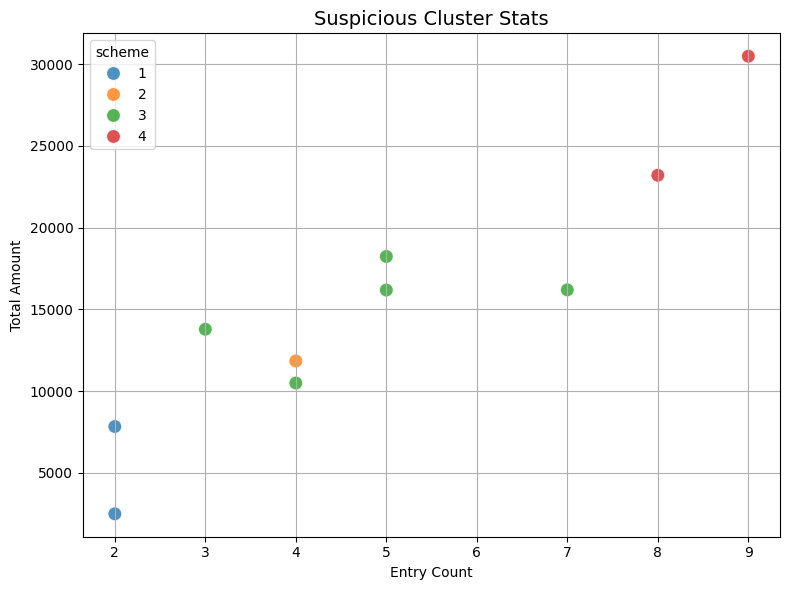

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=suspicious_clusters,
    x='entry_count',
    y='amount',
    hue='scheme',  # Add 'scheme' if multiple pension types involved
    palette='tab10',
    s=100,
    alpha=0.8
)

plt.title("Suspicious Cluster Stats", fontsize=14)
plt.xlabel("Entry Count")
plt.ylabel("Total Amount")
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Example: Weighted score (higher = more suspicious)
suspicious_clusters['risk_score'] = (
    0.5 * suspicious_clusters['amount'].rank(pct=True) +
    0.3 * suspicious_clusters['entry_count'].rank(pct=True) +
    0.2 * suspicious_clusters['scheme'].rank(pct=True)
)

suspicious_clusters.to_excel("suspicious_clusters_report.xlsx", index=False)


In [21]:
# Save flagged entries and suspicious clusters
suspicious_clusters.to_pickle("suspicious_clusters.pkl")
flagged.to_pickle("flagged_individuals.pkl")
